# Goal
Investigate how long the system running off of the UPS can sustain a power outage and continue to provide power to a building's infastructure. 

## Methodology
Use TrippLite's PowerAlert software to generate reports to then do statistical analysis using matplotlib and sklearn to dissect the logs for useable information. 

## Let's get into it
To start we will read in the CSV generated by PowerAlert. The logs generated are not remotely data science ready so we need to define a new index and clean up the data by dropping garbage rows and converting data types. For some reason the logging software spits out strings so this needs to be accounted for. 


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pprint import pprint

In [43]:
# Read the CSV file and clean up junk rows created by log dump
df = pd.read_csv('data/wclne_building_ups_battery.csv', header=2)

# Drop row defining unit of data
df = df.drop(index=0)

# Drop the 8 empty columns, sometimes with dual battery UPS units there are unnecessary columns here.
#df = df.drop(df.iloc[:, 1:9], axis = 1)

# Changes Battery Capacity and Runtime Remaining to a float, sometimes it gets imported as a string.
df['Battery Capacity'] = df['Battery Capacity'].astype(float)
df['Runtime Remaining (Min)'] = df['Runtime Remaining (Min)'].astype(float)

df.head(5)

,timestamp,Temperature (C) - Device,Runtime Remaining (Min),Battery Voltage,Battery Capacity,Input Frequency,Input Voltage,Output Frequency,Output Current,Output Utilization
1,2023-08-15 18:00:00,38.45,312.333333,40.90000000000005,100.0,59.80000000000006,120.82166666666672,59.80000000000006,0.0,15.65
2,2023-08-15 18:00:00,38.0,312.000000,40.9,100.0,59.8,121.4,59.8,0.0,16.0
3,2023-08-15 18:01:00,38.0,312.000000,40.9,100.0,59.8,121.4,59.8,0.0,15.0
4,2023-08-15 18:02:00,38.0,312.000000,40.9,100.0,59.8,121.4,59.8,0.0,15.0
5,2023-08-15 18:03:00,38.0,312.000000,40.9,100.0,59.8,121.4,59.8,0.0,16.0


## Data Cleaning
Data needs to be typed properly. The timestamp column is just a string that represents a date, not a date itself, we should change that. We should also create a Minutes Elapsed column to track the time between the start and end times of our experiment.

In [44]:
# Create a DataFrame for plotting observed data 

# Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Filter rows based on timestamp
cutoff_time = pd.to_datetime('2023-08-21 00:00')
filtered_df = df[df['timestamp'] >= cutoff_time]

# Set the desired start and end time for plotting
start_time = pd.to_datetime('2023-08-21 12:00')
end_time = pd.to_datetime('2023-08-21 15:00')

# Filter rows after start time and before end time
filtered_df = filtered_df[(filtered_df['timestamp'] >= start_time) & (filtered_df['timestamp'] <= end_time)]

# Transform timestamp column to minutes elapsed betweeen start_time and end_time
filtered_df['Minutes Elapsed'] = (filtered_df['timestamp'] - start_time).dt.total_seconds() / 60

# Fill in NaN values with a 0, effectively true due to NaN only being present in a power outage
filtered_df = filtered_df.fillna(0)

# Reset index since this is a slice of data from a larger table
filtered_df = filtered_df.reset_index(drop=True)

## Prediction
Create a new dataframe to run our model on consiting of just the timestamp and the runtime remaining. Get the coefficients, MSE, and r2 value for the regression line. Think of coefficients as the slope of the line, MSE is a value that should be small as it represents the average deviation of data points from the regression line, and the r2 value should be as close to 1 as we can get to be an accurate prediction. 

In [45]:
# Linear regression block

# Create a new DataFrame for prediction
prediction_df = pd.DataFrame()
prediction_df['timestamp'] = filtered_df['timestamp']
prediction_df['Runtime Remaining (Min)'] = filtered_df['Runtime Remaining (Min)']

# Remove rows with missing values
prediction_df = prediction_df.dropna()

# Convert timestamp to minutes elapsed from the start time
prediction_df['Minutes Elapsed'] = (prediction_df['timestamp'] - start_time).dt.total_seconds() / 60

# Train a linear regression model
model = LinearRegression()
model.fit(prediction_df[['Minutes Elapsed']], prediction_df['Runtime Remaining (Min)'])

# Create a range of minutes for prediction
minutes_range = pd.DataFrame({'Minutes Elapsed': range(0, int((end_time - start_time).total_seconds() / 60) + 1)})

# Predict battery drain using the linear regression model
predicted_drain = model.predict(minutes_range[['Minutes Elapsed']])

# The coefficients 
predicted_coefficients = model.coef_

# The Mean Squared Error
predicted_mse = mean_squared_error(prediction_df['Runtime Remaining (Min)'], predicted_drain)

# The coefficient of determination
predicted_r2 = r2_score(prediction_df['Runtime Remaining (Min)'], predicted_drain)

## Output Utilization 
The average utilization a percentage of the load the UPS is currently under. We want to track it over the course of the study to see if there are any changes to the load that the UPS is under.

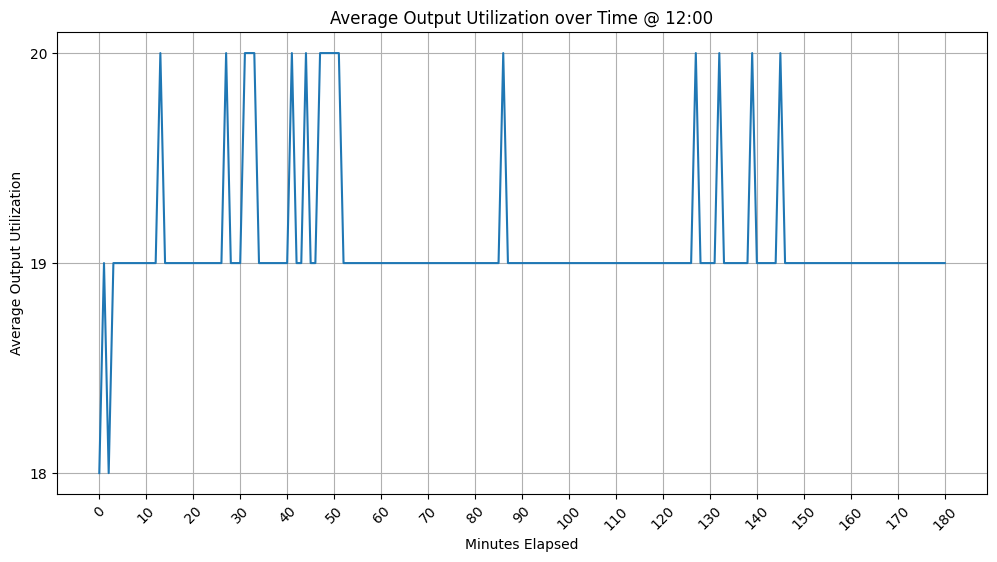

In [46]:
# Calculate the average Output Utilization 
average_output_utilization = filtered_df.groupby('Minutes Elapsed')['Output Utilization'].mean()

fig, ax = plt.subplots(figsize=(12, 6)) 
ax.plot(average_output_utilization.index, average_output_utilization.values)
ax.set_xlabel('Minutes Elapsed')
ax.set_ylabel('Average Output Utilization')
ax.set_title('Average Output Utilization over Time @ ' + start_time.strftime("%H:%M"))

loc_x = plticker.MultipleLocator(base=10.0)
loc_y = plticker.MultipleLocator(base=1.0)
ax.xaxis.set_major_locator(loc_x)
ax.yaxis.set_major_locator(loc_y)

plt.xticks(rotation=45)
plt.grid(True)

## Runtime Remaining
Its very much what it says on the tin. The below graph represents the estimated runtime left that the UPS can continue to provide power. In the perfect world this value should decrease to 0. 

Starting Point:
Timestamp: 08/21/23 at 12:00
Runtime Remaining: 266 minutes

Ending Point:
Timestamp: 08/21/23 at 15:00
Runtime Remaining: 87 minutes

Total Change in Runtime: 179 minutes


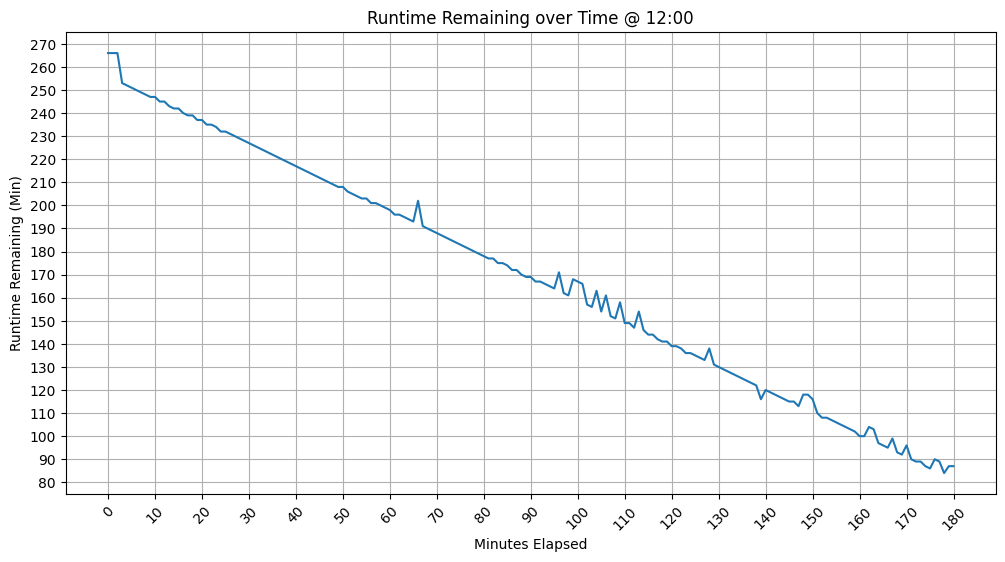

In [47]:
# Plot the data for Runtime Remaining over Time
fig, ax = plt.subplots(figsize=(12, 6)) 
ax.plot(filtered_df['Minutes Elapsed'], filtered_df['Runtime Remaining (Min)'], label='Runtime Remaining (Min)')
ax.set_xlabel('Minutes Elapsed')
ax.set_ylabel('Runtime Remaining (Min)')
ax.set_title('Runtime Remaining over Time @ ' + start_time.strftime("%H:%M"))

loc_x = plticker.MultipleLocator(base=10.0)
loc_y = plticker.MultipleLocator(base=10.0)
ax.xaxis.set_major_locator(loc_x)
ax.yaxis.set_major_locator(loc_y)

plt.xticks(rotation=45)
plt.grid(True)

# Print data at starting and ending points
start_data = filtered_df.iloc[0]
end_data = filtered_df.iloc[-1]

# Calculate total change in runtime
total_change = filtered_df['Runtime Remaining (Min)'].iloc[-1] - filtered_df['Runtime Remaining (Min)'].iloc[0]

# Display calculated data
print("Starting Point:")
print("Timestamp:", start_time.strftime("%D at %H:%M"))
print(f"Runtime Remaining: {start_data['Runtime Remaining (Min)']:.0f} minutes")

print("\nEnding Point:")
print("Timestamp:", end_time.strftime("%D at %H:%M"))
print(f"Runtime Remaining: {end_data['Runtime Remaining (Min)']:.0f} minutes")

print(f"\nTotal Change in Runtime: {-(total_change):.0f} minutes")

## Runtime Spikes
Sometimes there can be these odd spikes that can appear on the graph where power usage jumps for a minute or so. Lets take a closer look at these spikes to see if we can figure out any possible causes. 

In [48]:
# Investigate the spikes within the Runtime Graph

# Find sudden spikes in the data with spike_threshold 
spike_threshold = 5
spike_mask = filtered_df['Runtime Remaining (Min)'].diff() > spike_threshold
spike_df = filtered_df.loc[spike_mask].copy()

# Calculate the spike value by subtracting from the previous point
spike_df['Spike Value'] = spike_df['Runtime Remaining (Min)'] - filtered_df['Runtime Remaining (Min)'].shift(1)

# Print the new DataFrame with spike value
spike_df[['timestamp', 'Runtime Remaining (Min)', 'Minutes Elapsed', 'Spike Value']]

,timestamp,Runtime Remaining (Min),Minutes Elapsed,Spike Value
66,2023-08-21 13:06:00,202.0,66.0,9.0
96,2023-08-21 13:36:00,171.0,96.0,7.0
99,2023-08-21 13:39:00,168.0,99.0,7.0
104,2023-08-21 13:44:00,163.0,104.0,7.0
106,2023-08-21 13:46:00,161.0,106.0,7.0
109,2023-08-21 13:49:00,158.0,109.0,7.0
113,2023-08-21 13:53:00,154.0,113.0,7.0


## Battery Capacity
The battery capacity should decrease to 0 in a smooth line over time.

Starting Point:
Timestamp: 08/21/23 at 12:00
Battery Capacity: 100%

Ending Point:
Timestamp: 08/21/23 at 15:00
Battery Capacity: 32%

Total Battery Capacity drain: 68%
Average Battery Capacity Lost Per Minute: -0.38%


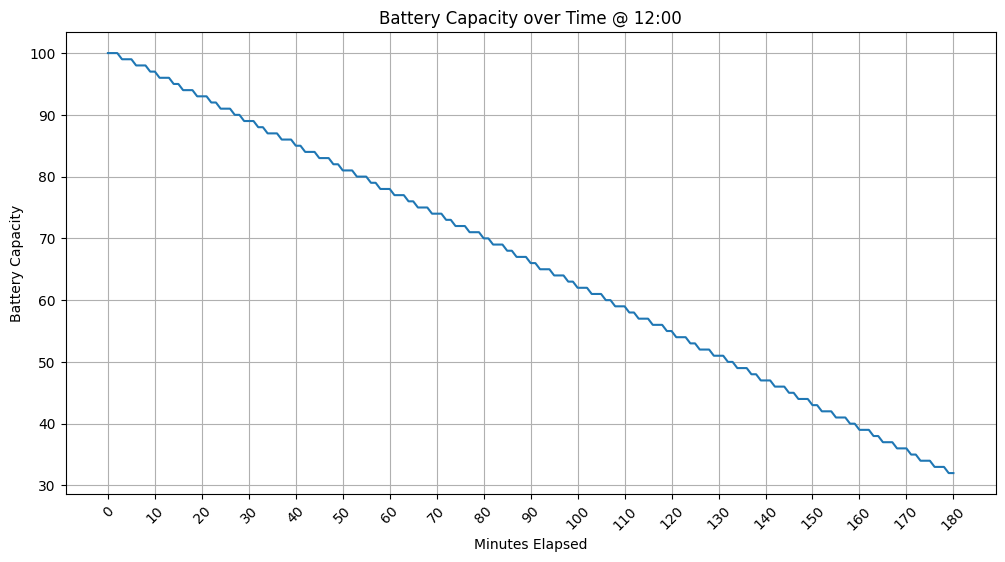

In [49]:
# Plot the data for Battery Capacity over Time
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(filtered_df['Minutes Elapsed'], filtered_df['Battery Capacity'])
ax.set_xlabel('Minutes Elapsed')
ax.set_ylabel('Battery Capacity')
ax.set_title('Battery Capacity over Time @ ' + start_time.strftime("%H:%M"))

loc_x = plticker.MultipleLocator(base=10.0)
loc_y = plticker.MultipleLocator(base=10.0)
ax.xaxis.set_major_locator(loc_x)
ax.yaxis.set_major_locator(loc_y)

plt.xticks(rotation=45)
plt.grid(True)

# Print data at starting and ending points
start_data = filtered_df.iloc[0]
end_data = filtered_df.iloc[-1]

# Calculate total change in runtime
total_change = filtered_df['Battery Capacity'].iloc[-1] - filtered_df['Battery Capacity'].iloc[0]

# Calculate the average battery capacity lost every minute
total_capacity_lost = filtered_df['Battery Capacity'].iloc[-1] - filtered_df['Battery Capacity'].iloc[0]
total_minutes = (end_time - start_time).total_seconds() / 60
average_capacity_lost_per_minute = total_capacity_lost / total_minutes

# Display calculated data
print("Starting Point:")
print("Timestamp:", start_time.strftime("%D at %H:%M"))
print(f"Battery Capacity: {start_data['Battery Capacity']:.0f}%")

print("\nEnding Point:")
print("Timestamp:", end_time.strftime("%D at %H:%M"))
print(f"Battery Capacity: {end_data['Battery Capacity']:.0f}%")

print(f"\nTotal Battery Capacity drain: {-(total_change):.0f}%")
print(f"Average Battery Capacity Lost Per Minute: {average_capacity_lost_per_minute:.2f}%")

## Runtime and Battery Together
For the sake of it, lets see both of the graphs above on the same plane. 

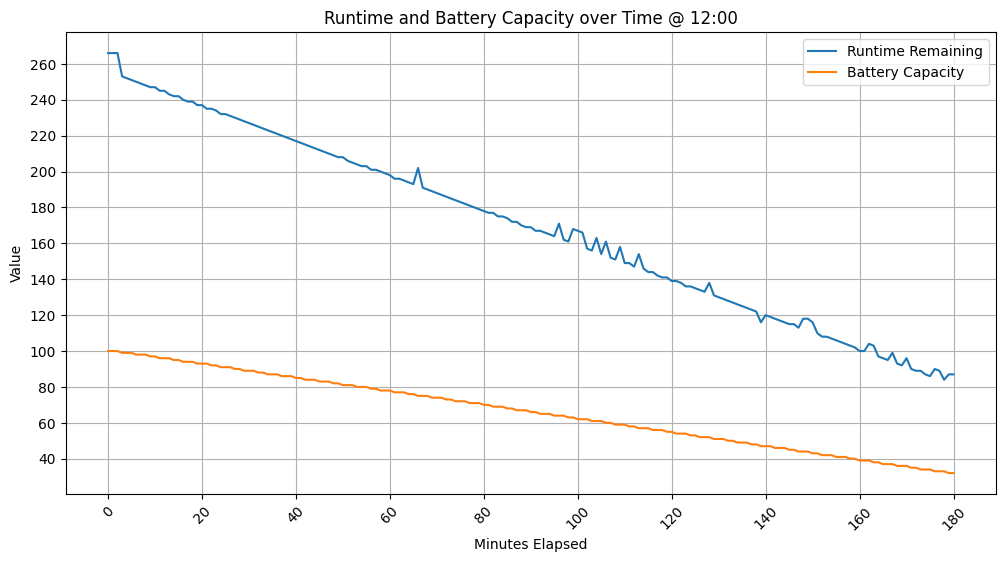

In [50]:
# Plot the data for both overlayed
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(filtered_df['Minutes Elapsed'], filtered_df['Runtime Remaining (Min)'], label='Runtime Remaining')
ax.plot(filtered_df['Minutes Elapsed'], filtered_df['Battery Capacity'], label='Battery Capacity')
ax.set_xlabel('Minutes Elapsed')
ax.set_ylabel('Value')
ax.set_title('Runtime and Battery Capacity over Time @ ' + start_time.strftime("%I:%M"))

loc_x = plticker.MultipleLocator(base=20.0)
loc_y = plticker.MultipleLocator(base=20.0)
ax.xaxis.set_major_locator(loc_x)
ax.yaxis.set_major_locator(loc_y)

plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

## Plot the Regression
Now that we have taken a look at both of the other metrics for this test, lets see if we can acurately predict how minutes elapsed and runtime remaining relate to one another. The other graphs are both fairly straight lines so if the UPS is healthy and there are no unexpected sources of power draw, this value should be spot on. 

Coefficients: -0.9652
Mean Squared Error: 6.66
Coefficient of determination: 1.00


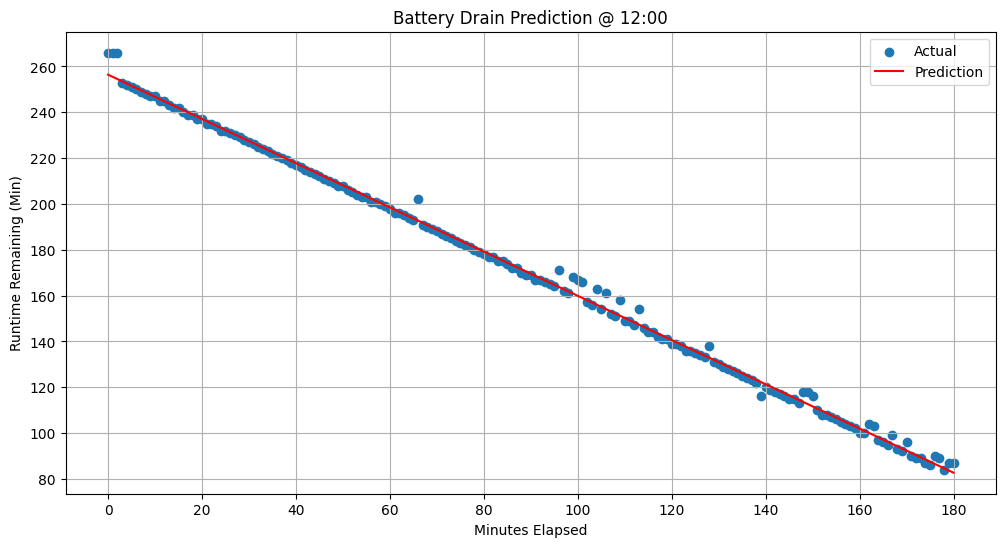

: 

In [51]:
# Plot the data and prediction
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(prediction_df['Minutes Elapsed'], prediction_df['Runtime Remaining (Min)'], label='Actual')
ax.plot(minutes_range['Minutes Elapsed'], predicted_drain, color='red', label='Prediction')
ax.set_xlabel('Minutes Elapsed')
ax.set_ylabel('Runtime Remaining (Min)')
ax.set_title('Battery Drain Prediction @ ' + start_time.strftime("%I:%M"))

loc_x = plticker.MultipleLocator(base=20.0)
loc_y = plticker.MultipleLocator(base=20.0)
ax.xaxis.set_major_locator(loc_x)
ax.yaxis.set_major_locator(loc_y)

plt.grid(True)
plt.legend()

print(f"Coefficients: {predicted_coefficients[0]:.4f}")
print(f"Mean Squared Error: {predicted_mse:.2f}")
print(f"Coefficient of determination: {predicted_r2:.2f}")